# Course : EE 559 Deep Learning
# Authors: Ankita Humne, Elliot, Harshvardhan
# Test code to run our best solution for Mini Project 1 

In [2]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import dlc_practical_prologue as prologue
%matplotlib inline
N=1000
from torch.utils.data import DataLoader, Dataset
import tqdm
from torch.autograd import Variable

In [8]:
# Chosen best architecture:
# 1. Weight Sharing
# 2. Without auxillary loss
# 3. Batch normalisation
# 4. Activation function: ReLU
# 5. Convolution layers for the base
print('Chosen best architecture with convolution layers for feature extraction, weight sharing, no auxillary loss with Batch normalization')
class CompareNet(nn.Module): # without auxillary loss
    def __init__(self,batch_normalization = True):
        super(CompareNet, self).__init__()
        if batch_normalization:
            self.base = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.BatchNorm2d(32),nn.Conv2d(32, 8, kernel_size=3),nn.MaxPool2d(kernel_size=2))
        else:
            self.base = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3),nn.MaxPool2d(kernel_size=2),nn.Conv2d(32, 8, kernel_size=3),nn.MaxPool2d(kernel_size=2))
        self.comparator = nn.Linear(64,2)
        
    def forward(self, x):
        x_0 = x[:,:1,:,:]
        x_1 = x[:,1:2,:,:]
        x_0 = F.relu(self.base(x_0)) 
        x_1 = F.relu(self.base(x_1))
        x_0 = x_0.view(-1,32)
        x_1 = x_1.view(-1,32)
        sign = F.relu(self.comparator(torch.cat([x_0,x_1],dim = 1)))
        return sign

Chosen best architecture with convolution layers for feature extraction, weight sharing, no auxillary loss with Batch normalization


In [9]:
class DigitPairsDataset(Dataset):
    def __init__(self,img_pair,targets, classes):
        super(DigitPairsDataset, self).__init__()
        self.img_pair = img_pair
        self.targets = targets
        self.classes = classes
    
    def __len__(self):
        return self.targets.size()[0]
    
    def __getitem__(self, idx):
        return self.img_pair[idx], self.targets[idx], self.classes[idx]

In [10]:
criterion = nn.CrossEntropyLoss()
net = CompareNet()
 
mu = 1.0
optimizer = optim.Adam(net.parameters(),lr = 0.001)
batch_normalization = True



In [11]:
# Function to calculate accuracy during training and validation

def calc_accuracy(data_loader,model):
    correct_count = 0.0
    for i, data in enumerate(data_loader,0):
        img_pair, target, classes = data
        pred_sign = net(img_pair)
        loss = criterion(pred_sign,target)
        pred = torch.argmax(pred_sign,-1)
        correct_count += int((target.eq(pred)).sum())
    return correct_count*100.0/N

In [13]:
nb_iterations = 1
count = 0
epochs = 50
print('This code generates runs the best chosen solution for {nb_iterations} iteration. To increase the number of iterations, please change nb_iterations'.format(nb_iterations=nb_iterations))

This code generates runs the best chosen solution for 1 iteration. To increase the number of iterations, please change nb_iterations


 18%|██████████████▉                                                                    | 9/50 [00:09<00:44,  1.09s/it]

Epoch : 9  ,   Train Accuracy : 93.20  , Validation Accuracy : 79.00 , Training Loss : 0.006841


 38%|███████████████████████████████▏                                                  | 19/50 [00:21<00:38,  1.25s/it]

Epoch : 19  ,   Train Accuracy : 99.00  , Validation Accuracy : 81.40 , Training Loss : 0.002964


 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:35<00:28,  1.35s/it]

Epoch : 29  ,   Train Accuracy : 100.00  , Validation Accuracy : 81.80 , Training Loss : 0.001077


 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:52<00:21,  1.91s/it]

Epoch : 39  ,   Train Accuracy : 100.00  , Validation Accuracy : 81.10 , Training Loss : 0.000498


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:09<00:01,  1.60s/it]

Epoch : 49  ,   Train Accuracy : 100.00  , Validation Accuracy : 81.80 , Training Loss : 0.000261


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


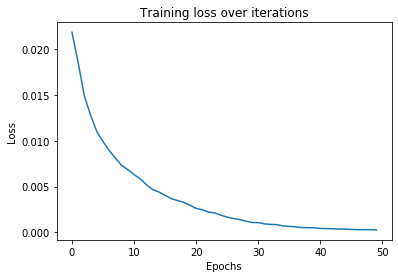

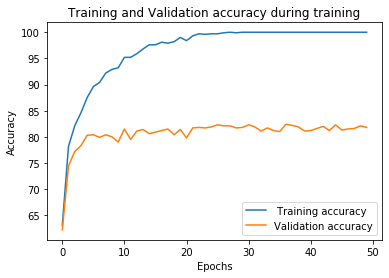

In [15]:


while count<nb_iterations:
    loss_arr = []
    train_acc_arr = []
    val_acc_arr = []
    train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(N)
    train_dataset = DigitPairsDataset(train_input,train_target,train_classes)
    test_dataset = DigitPairsDataset(test_input,test_target,test_classes)
    train_loader = DataLoader(train_dataset,batch_size=32, shuffle = True, num_workers = 0)
    test_loader = DataLoader(test_dataset,batch_size=32, shuffle = True, num_workers = 0)
    for epoch in tqdm.tqdm(range(epochs)):
        net.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader,0):
            img_pair, target, classes = data

            optimizer.zero_grad()
        
            pred_sign = net(img_pair)
            loss = criterion(pred_sign,target)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        net.eval()
        running_loss /= N
        loss_arr.append(running_loss)
        train_acc = calc_accuracy(train_loader,net)
        val_acc = calc_accuracy(test_loader,net)
        train_acc_arr.append(train_acc)
        val_acc_arr.append(val_acc)
        if epoch % 10 == 9:
            print("Epoch : %d  ,   Train Accuracy : %.2f  , Validation Accuracy : %.2f , Training Loss : %.6f" %(epoch, train_acc, val_acc, running_loss))


    plt.plot(range(epochs),loss_arr)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training loss over iterations")
    fileplot1 = "plot_loss_{count}.png".format(count=count)
    plt.savefig(fileplot1)
    plt.show()

    plt.plot(range(epochs),train_acc_arr, label  =" Training accuracy")
    plt.plot(range(epochs), val_acc_arr, label ="Validation accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.title("Training and Validation accuracy during training")
    plt.legend()
    fileplot = "plot_acc_{count}.png".format(count=count)
    plt.savefig(fileplot)
    plt.show()



    fileloss = "loss_{count}.npy".format(count=count)
    np.save(fileloss,loss_arr)
    filetrain = "train_acc_{count}.npy".format(count=count)
    np.save(filetrain,train_acc_arr)
    fileval = "val_acc_{count}.npy".format(count=count)
    np.save(fileval,val_acc_arr)
    count+= 1
